<a href="https://colab.research.google.com/github/TUstudents/gauche/blob/main/notebooks/02_GP_Regression_on_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import sys
if 'google.colab' in sys.modules:
    print('In colab!')
    ! rm -rf gauche
    !git clone https://github.com/TUstudents/gauche
    sys.path.insert(0,'gauche')
    !pip install rxnfp --no-deps
    !pip install --no-deps drfp
    !pip install faerun mordredcommunity

In colab!
Cloning into 'gauche'...
remote: Enumerating objects: 2374, done.
remote: Counting objects: 100% (663/663), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 2374 (delta 499), reused 478 (delta 453), pack-reused 1711
Receiving objects: 100% (2374/2374), 35.98 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (1341/1341), done.


In [3]:
if 'google.colab' in sys.modules:
    !pip install transformers
    !pip install gpflow grakel

In [4]:
if 'google.colab' in sys.modules:
  !pip install gauche

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
graphein 1.7.6 requires typing-extensions==4.5.0, but you have typing-extensions 4.10.0 which is incompatible.


In [6]:
#if 'google.colab' in sys.modules:
#    !pip install graphein
# Graphein sometimes does not install successfully on colab

  Using cached graphein-1.7.6-py3-none-any.whl (310 kB)
  Using cached biopandas-0.5.1.dev0-py3-none-any.whl (1.2 MB)
  Using cached biopython-1.83-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached bioservices-1.11.2.tar.gz (191 kB)
  Preparing metadata (setup.py) ... done
  Using cached deepdiff-6.7.1-py3-none-any.whl (76 kB)
  Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
  Using cached looseversion-1.3.0-py2.py3-none-any.whl (8.2 kB)
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached rich_click-1.7.4-py3-none-any.whl (32 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 13.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pydantic to determine which version is

In [5]:
!pip show gauche

Name: gauche
Version: 0.1.6
Summary: Gaussian Process Library for Molecules, Chemical Reactions and Proteins.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: botorch, gpytorch, ipykernel, jupyterlab, matplotlib, numpy, pandas, rdkit, scikit-learn, scipy, seaborn, selfies, torch, tqdm
Required-by: 


In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cpu


# GP Regression on Molecules #

An example notebook for basic GP regression on a molecular dataset. We showcase two different GP models on the Photoswitch Dataset --- one using a Tanimoto kernel applied to fingerprint representations of the molecules and another also using a Tanimoto kernel but applied to a bag-of-characters representations of molecular SMILES strings (a.k.a the bag-of-SMILES model). Towards the end of the tutorial it is shown that the GP's uncertainty estimates are correlated with prediction error and can thus act as a criteria for prioritising molecules for laboratory synthesis.

Paper: https://pubs.rsc.org/en/content/articlelanding/2022/sc/d2sc04306h

Code: https://github.com/Ryan-Rhys/The-Photoswitch-Dataset


In [7]:
# Imports

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

import time

from botorch import fit_gpytorch_model
import gpytorch
from mordred import Calculator, descriptors
import numpy as np
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
#import torch

from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data

We define our model. See

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

for further examples!

## Defining a Molecular Kernel ##

The first step is to define a Gaussian process model with a kernel that operates on molecular fingerprints (e.g. ECFP6). For this we use the Tanimoto kernel defined as:

\begin{equation}
k_{\text{Tanimoto}}(\mathbf{x}, \mathbf{x}') = \sigma^2_{f}\frac{<\mathbf{x}, \mathbf{x}'>}{||\mathbf{x}||^2 + ||\mathbf{x}'||^2 \: - <\mathbf{x}, \mathbf{x}'>},
\end{equation}

where $\mathbf{x} \in \mathbb{R}^D$ is a D-dimensional binary fingerprint vector i.e. components $\mathbf{x}_i \in \{0, 1\}$, $<\cdot, \cdot>$ is the Euclidean inner product, $||\cdot||$ is the Euclidean norm and $\sigma_{f}$ is a scalar kernel signal amplitude (vertical lengthscale) hyperparameter. One of the first instances of the Tanimoto kernel being used in conjunction with GP regression was in [1]. While common GP kernels that operate on continuous spaces can be applied to molecules, there is evidence to suggest that using an appropriate similarity metric for bit vectors yields improved performance [2].



In [8]:
# We define our GP model using the Tanimoto kernel

from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from gpytorch.kernels import RQKernel

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # We use the Tanimoto kernel to work with molecular fingerprint representations
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# For the continuous Mordred descriptors we use a GP with rational quadratic kernel

class ExactMordredGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactMordredGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # We use the RQ kernel to work with Mordred descriptors
        self.covar_module = gpytorch.kernels.ScaleKernel(RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## GP Regression on the Photoswitch Dataset ##

We define our experiment parameters. In this case we are reproducing the results of the E isomer transition wavelength prediction task from https://arxiv.org/abs/2008.03226 using 20 random splits in the ratio 80/20. Note that a validation set is not necessary for GP regression since the Tanimoto kernel GP has just one trainable hyperparameter, the kernel signal amplitude! (or two if the likelihood noise is considered!).

In [9]:
# Regression experiments parameters, number of random splits and split size

n_trials = 20
test_set_size = 0.2

Load the Photoswitch Dataset via the DataLoaderMP class which contains several molecular property prediction benchmark datasets!

In [10]:
# Load the Photoswitch dataset

loader = MolPropLoader()
loader.load_benchmark("Photoswitch")

# Featurise the molecules.

# We use the fragprints representations (a concatenation of Morgan fingerprints and RDKit fragment features)

loader.featurize('ecfp_fragprints')
X_fragprints = loader.features
y = loader.labels

# we can also consider a bag of characters summary of the molecule's SMILES string representations
loader.load_benchmark("Photoswitch")
loader.featurize('bag_of_smiles', max_ngram=5)
X_boc = loader.features

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).
Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).


We can also use Mordred descriptors [3] which produce state-of-the-art results on the Photoswitch Dataset. We preprocess the Mordred descriptors to remove NaN features and features that have a variance threshold smaller than 0.05 post-standardization.

In [11]:
"""Compute Mordred descriptors."""

loader = MolPropLoader()
loader.load_benchmark("Photoswitch")

# Mordred descriptor computation is expensive
calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in loader.features]
t0 = time.time()
X_mordred = [calc(mol) for mol in mols]
t1 = time.time()
print(f'Mordred descriptor computation takes {t1 - t0} seconds')
X_mordred = np.array(X_mordred).astype(np.float64)

"""Collect nan indices"""

nan_dims = []

for i in range(len(X_mordred)):
    nan_indices = list(np.where(np.isnan(X_mordred[i, :]))[0])
    for dim in nan_indices:
        if dim not in nan_dims:
            nan_dims.append(dim)

X_mordred = np.delete(X_mordred, nan_dims, axis=1)

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).
Mordred descriptor computation takes 98.84386539459229 seconds


## Model Evaluation ##

Here we define a training/evaluation loop assessing performance using the root mean-square error (RMSE), mean average error (MAE), and $R^2$ metrics. The `evaluate_model` function also computes the GP confidence-error curve which will be explained below.

In [12]:
import warnings
warnings.filterwarnings("ignore") # Turn off GPyTorch warnings

from matplotlib import pyplot as plt
%matplotlib inline


def evaluate_model(X, y, use_mordred=False):
    """Helper function for model evaluation.

    Args:
        X: n x d NumPy array of inputs representing molecules
        y: n x 1 NumPy array of output labels
        use_mordred: Bool specifying whether the X features are mordred descriptors. If yes, then apply PCA.
    Returns:
        regression metrics and confidence-error curve plot.
    """

    # initialise performance metric lists
    r2_list = []
    rmse_list = []
    mae_list = []

    # We pre-allocate array for plotting confidence-error curves

    _, _, _, y_test = train_test_split(X, y, test_size=test_set_size)  # To get test set size
    n_test = len(y_test)

    mae_confidence_list = np.zeros((n_trials, n_test))

    print('\nBeginning training loop...')

    for i in range(0, n_trials):

        print(f'Starting trial {i}')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=i)

        if use_mordred:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            pca_mordred = PCA(n_components=51)
            X_train = pca_mordred.fit_transform(X_train)
            X_test = pca_mordred.transform(X_test)

        #  We standardise the outputs
        _, y_train, _, y_test, y_scaler = transform_data(X_train, y_train, X_test, y_test)

        # Convert numpy arrays to PyTorch tensors and flatten the label vectors
        X_train = torch.tensor(X_train.astype(np.float64))
        X_test = torch.tensor(X_test.astype(np.float64))
        y_train = torch.tensor(y_train).flatten()
        y_test = torch.tensor(y_test).flatten()

        # initialise GP likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        if use_mordred:
            model = ExactMordredGPModel(X_train, y_train, likelihood)
        else:
            model = ExactGPModel(X_train, y_train, likelihood)

        # Find optimal model hyperparameters
        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        # Use the BoTorch utility for fitting GPs in order to use the LBFGS-B optimiser (recommended)
        fit_gpytorch_model(mll)

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        # mean and variance GP prediction
        f_pred = model(X_test)

        y_pred = f_pred.mean
        y_var = f_pred.variance

        # Transform back to real data space to compute metrics and detach gradients. Must unsqueeze dimension
        # to make compatible with inverse_transform in scikit-learn version > 1
        y_pred = y_scaler.inverse_transform(y_pred.detach().unsqueeze(dim=1))
        y_test = y_scaler.inverse_transform(y_test.detach().unsqueeze(dim=1))

        # Compute scores for confidence curve plotting.

        ranked_confidence_list = np.argsort(y_var.detach(), axis=0).flatten()

        for k in range(len(y_test)):

            # Construct the MAE error for each level of confidence

            conf = ranked_confidence_list[0:k+1]
            mae = mean_absolute_error(y_test[conf], y_pred[conf])
            mae_confidence_list[i, k] = mae

        # Output Standardised RMSE and RMSE on Train Set
        y_train = y_train.detach()
        y_pred_train = model(X_train).mean.detach()
        train_rmse_stan = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_rmse = np.sqrt(mean_squared_error(y_scaler.inverse_transform(y_train.unsqueeze(dim=1)),
                                                y_scaler.inverse_transform(y_pred_train.unsqueeze(dim=1))))

        # Compute R^2, RMSE and MAE on Test set
        score = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        r2_list.append(score)
        rmse_list.append(rmse)
        mae_list.append(mae)

    r2_list = np.array(r2_list)
    rmse_list = np.array(rmse_list)
    mae_list = np.array(mae_list)

    print("\nmean R^2: {:.4f} +- {:.4f}".format(np.mean(r2_list), np.std(r2_list)/np.sqrt(len(r2_list))))
    print("mean RMSE: {:.4f} +- {:.4f}".format(np.mean(rmse_list), np.std(rmse_list)/np.sqrt(len(rmse_list))))
    print("mean MAE: {:.4f} +- {:.4f}\n".format(np.mean(mae_list), np.std(mae_list)/np.sqrt(len(mae_list))))

    # Plot confidence-error curves

    # 1e-14 instead of 0 to for numerical reasons!
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))

    # We plot the Mean-absolute error confidence-error curves

    mae_mean = np.mean(mae_confidence_list, axis=0)
    mae_std = np.std(mae_confidence_list, axis=0)

    mae_mean = np.flip(mae_mean)
    mae_std = np.flip(mae_std)

    # 1 sigma errorbars

    lower = mae_mean - mae_std
    upper = mae_mean + mae_std

    plt.plot(confidence_percentiles, mae_mean, label='mean')
    plt.fill_between(confidence_percentiles, lower, upper, alpha=0.2)
    plt.xlabel('Confidence Percentile')
    plt.ylabel('MAE (nm)')
    plt.ylim([0, np.max(upper) + 1])
    plt.xlim([0, 100 * ((len(y_test) - 1) / len(y_test))])
    plt.yticks(np.arange(0, np.max(upper) + 1, 5.0))
    plt.show()

    return rmse_list, mae_list


Check the perfomance achieved by our fingerprint model. The mean RMSE should be ca. 20.9 +- 0.7 nanometres!


Beginning training loop...
Starting trial 0
Starting trial 1
Starting trial 2
Starting trial 3
Starting trial 4
Starting trial 5
Starting trial 6
Starting trial 7
Starting trial 8
Starting trial 9
Starting trial 10
Starting trial 11
Starting trial 12
Starting trial 13
Starting trial 14
Starting trial 15
Starting trial 16
Starting trial 17
Starting trial 18
Starting trial 19

mean R^2: 0.8974 +- 0.0056
mean RMSE: 20.8576 +- 0.6607
mean MAE: 13.2809 +- 0.3296



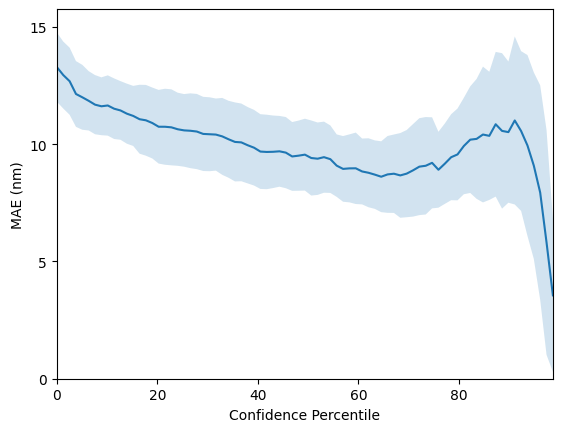

In [13]:
rmse_fragprints, mae_fragprints = evaluate_model(X_fragprints, y)

We can do the same for our bag-of-SMILES model. However, for this particular task, perfomance is a little worse at 23.2 +-0.8 nanometres.


Beginning training loop...
Starting trial 0
Starting trial 1
Starting trial 2
Starting trial 3
Starting trial 4
Starting trial 5
Starting trial 6
Starting trial 7
Starting trial 8
Starting trial 9
Starting trial 10
Starting trial 11
Starting trial 12
Starting trial 13
Starting trial 14
Starting trial 15
Starting trial 16
Starting trial 17
Starting trial 18
Starting trial 19

mean R^2: 0.8721 +- 0.0082
mean RMSE: 23.2011 +- 0.8030
mean MAE: 14.6870 +- 0.4231



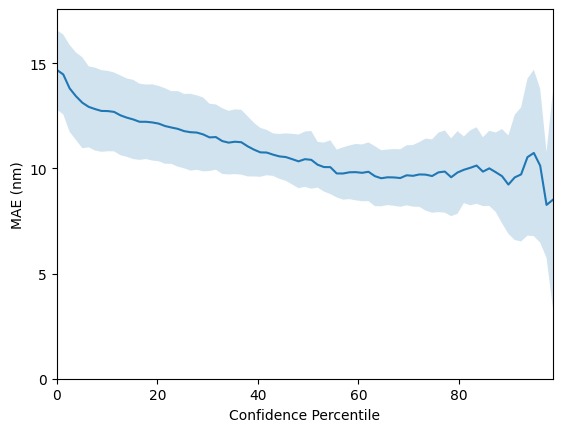

In [14]:
rmse_boc, mae_boc = evaluate_model(X_boc, y)

Mordred descriptors obtain state-of-the-art results of


Beginning training loop...
Starting trial 0
Starting trial 1
Starting trial 2
Starting trial 3
Starting trial 4
Starting trial 5
Starting trial 6
Starting trial 7
Starting trial 8
Starting trial 9
Starting trial 10
Starting trial 11
Starting trial 12
Starting trial 13
Starting trial 14
Starting trial 15
Starting trial 16
Starting trial 17
Starting trial 18
Starting trial 19

mean R^2: 0.9143 +- 0.0046
mean RMSE: 19.0709 +- 0.5316
mean MAE: 12.5125 +- 0.2187



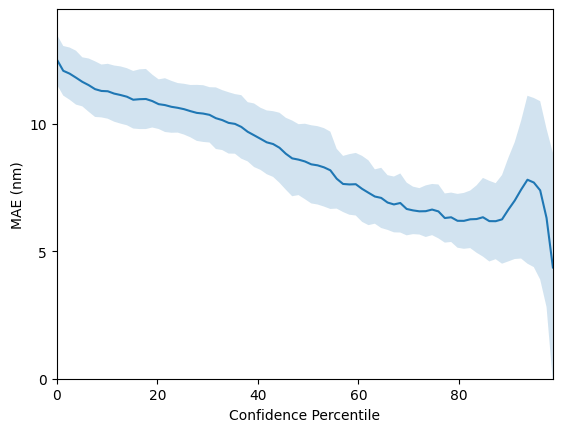

In [15]:
rmse_mordred, mae_mordred = evaluate_model(X_mordred, y, use_mordred=True)

Perform a Wilcoxon signed rank test to assess statistical significance of the difference between mordred descriptors and fragprints

In [16]:
"""Wilcoxon signed rank test"""

from scipy.stats import wilcoxon

# RMSE
print(f'Wilcoxon Signed Rank Test on the RMSE metric is:\n {wilcoxon(rmse_fragprints, rmse_mordred)}\n')

# MAE
print(f'Wilcoxon Signed Rank Test on the MAE metric is:\n {wilcoxon(mae_fragprints, mae_mordred)}\n')

Wilcoxon Signed Rank Test on the RMSE metric is:
 WilcoxonResult(statistic=12.0, pvalue=0.000133514404296875)

Wilcoxon Signed Rank Test on the MAE metric is:
 WilcoxonResult(statistic=33.0, pvalue=0.005580902099609375)



## Using the GP Uncertainty Estimates ##

So far we have only considered the GP as a regressor and have not considered use-cases for the GP's uncertainty estimates. One such use-case is virtual screening applications where one would like to use model uncertainty as a criteria for prioritising molecules for synthesis; the intuition is that if two molecules have the same predicted property under the model, it will be desirable to choose the one where the model has highest confidence or equivalently lowest uncertainty. To assess whether a model's confidence is correlated with prediction error, one may plot a confidence-error curve as illustrated below.

<p align="center">
  <a>
    <img src="https://github.com/TUstudents/gauche/blob/main/notebooks/assets/confidence_curve.png?raw=1" width="35%" />
  </a>
</p>

The x-axis, `Confidence Percentile`, ranks each test datapoint prediction according to the GP predictive variance. For example, molecules that reside above the 80th confidence percentile will correspond to the 20% of test set molecules with the lowest GP predictive uncertainty. The prediction error at each confidence percentile is then measured over 20 random train/test splits (the standard error over the random splits is plotted in the figure above) to gauge if the model’s confidence is correlated with the prediction error. The figure above shows that the SMILES GP's uncertainty estimates are positively correlated with the prediction error. As such, it is possible that model uncertainty could be used as a component in the decision-making process for prioritising molecules for laboratory synthesis.

## References

[1] Griffiths, R.R., Greenfield, J.L., Thawani, AR, Jamasb, A., Moss, H.B, Bourached, A., Jones, P., McCorkindale, W., Aldrick, A.A. Fuchter, M.J. and Lee, A.A., [Data-driven discovery of molecular photoswitches with multioutput Gaussian processes](https://pubs.rsc.org/en/content/articlehtml/2022/sc/d2sc04306h). Chemical Science 2022.

[2] Bajusz, D., Rácz, A. and Héberger, K., 2015. [Why is Tanimoto index an appropriate choice for fingerprint-based similarity calculations?](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3). Journal of Cheminformatics, 7(1), pp.1-13.

[3] Moriwaki, H., Tian, Y.S., Kawashita, N. and Takagi, T., 2018. [Mordred: a molecular descriptor calculator](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y?ref=https://githubhelp.com). Journal of Cheminformatics, 10(1), pp.1-14.